In [1]:
import math
import json
import pickle
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
from helper import load_mice_data, average_time_data, average_nonzero_duration, average_freq, frames_per_minute, frames_per_day

In [3]:
frame_within, frame_within_tail_behind, frame_within_tail_front, bout_start, bout_end, bout_duration, idx_order = load_mice_data(group="main")

In [4]:
near, near_behind, near_front = average_time_data(frame_within, frame_within_tail_behind, frame_within_tail_front, frames_per_minute, frames_per_minute, 1)
bout_duration_avg = average_nonzero_duration(frame_within, bout_duration, frames_per_minute, frames_per_minute, 1)
bout_freq = average_freq(frame_within, bout_start, frames_per_minute, frames_per_minute, 1, dataset="main")

/opt/anaconda3/envs/py39/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py39/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Trajectory Bars

In [5]:
timid_animals = set([18, 13, 8, 25, 21, 9, 4, 2, 15])
intermediate_animals = set([10, 11, 24, 17, 1, 6])
confident_animals = set([5, 16, 20, 12, 19, 0, 22, 23, 14, 3, 7])

In [6]:
def plot_matrix(rm, cmap, vmin, vmax, size=(20, 20), title='Title', y_labels=None, day_label=None):
    plt.figure(figsize=size, dpi=80)
    plt.imshow(rm, interpolation='nearest', cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    if y_labels != None:
        plt.yticks(list(range(len(y_labels))), y_labels)
    else:
        plt.yticks([])
    if day_label:
        plt.xticks([0, 25, 50, 75], ["D1", "D2", "D3", "D4"])
    else:
        plt.xticks([])
    plt.tight_layout()
    plt.show()

In [7]:
approach_bands = [0.0, 1.111111e-06, 0.1, 0.25]
duration_bands = [0.0, 0.01, 1.5, 3]
freq_bands_min = [0.0, 0.1, 1, 4, 7, 10]
freq_bands = np.array(freq_bands_min)/900.0

In [8]:
acolors = ['#999999','#d0efff','#187bcd','#064893','#ACDF87','#4C9A2A','#287140','#7851A9']
dcolors = ['#999999','#f7f5bc', '#e5de00', '#e47200']
fcolors = ['#999999','#ffcbd1', '#ee6b6e', '#ff2c2c', '#de0a26', '#c30010']
all_colors = acolors + dcolors + fcolors
amap = colors.ListedColormap(acolors)
dmap = colors.ListedColormap(dcolors)
fmap = colors.ListedColormap(fcolors)
allmap = colors.ListedColormap(all_colors)

In [9]:
def belongs_to_band(bands, value):
    bands = np.array(bands)
    return bands[bands <= value].argmax()

## Define how to Map Model Stats Back to Animal Space

In [10]:
def duration_map(x):
    # suppose we have bands: (0, w), (w, 2w), (2w, 3w)
    # let Δ = w/2, then x⁺ = Δ + 2Δ(x-2)
    delta = 0.75
    return max([delta + 2*delta*(x-2.0), 0.0])

def cutoff_map(x):
    return int(x/2)

def time_map(d, f):
    return (f*900*d)/60

In [11]:
def encode_traj_levels(x1, x2, x3, x4):  # input order: confident approach, cautious approach, duration, freq
    confident_band = belongs_to_band(approach_bands, x1)
    cautious_band = belongs_to_band(approach_bands, x2)
    duration_code = belongs_to_band(duration_bands, x3)
    freq_code = belongs_to_band(freq_bands, x4)
    
    appr_code = None
    appr_dom_code = None

    if (confident_band == 0) and (cautious_band == 0):
        appr_code = 0
        appr_dom_code = 0        
    elif (confident_band > 0) and (cautious_band > 0):
        appr_code = 7

        if confident_band >= cautious_band:
            appr_dom_code = confident_band            
        else:
            appr_dom_code = cautious_band + 3
    else:
        if (confident_band > 0):
            appr_code = confident_band
            appr_dom_code = confident_band
        else:
            appr_code = cautious_band + 3
            appr_dom_code = cautious_band + 3

    return appr_code, appr_dom_code, duration_code, freq_code
                        
    
def traj_bars(near, near_front, near_behind, bout_duration_avg, bout_freq,
              animals=None, print_fn=None, write_targ=False, smooth_window=None,
              preloaded_targets=None, best_sample_stats=None):

    iter_list = idx_order if animals is None else animals
    all_appr_list = []
    all_appr_dom_list = []
    all_dur_list = []
    all_freq_list = []
    phase_appr_list = []
    phase_dur_list = []
    phase_freq_list = []
    model_appr_list = []
    model_dur_list = []
    model_freq_list = []
    raw_values_time_all = []
    raw_values_dur_all = []
    raw_values_freq_all = []

    gt_targets = {}

    for i in iter_list:
        if print_fn is not None:
            print_fn(i)
        
        x1, x2, x3, x4 = near_front[i], near_behind[i], bout_duration_avg[i], bout_freq[i] 
        
        appr_list = []
        appr_dom_list = []
        dur_list = []
        freq_list = []
        raw_values_time = []
        raw_values_dur = []
        raw_values_freq = []

        appr_smooth = []
        appr_dom_smooth = []
        dur_smooth = []
        freq_smooth = []
        
        for t in range(len(x1)-100, len(x1)):
            # non-smooth plot
            appr_code, appr_dom_code, duration_code, freq_code = encode_traj_levels(x1[t], x2[t], x3[t], x4[t])

            if appr_dom_code > 3:
                raw_values_time.append(x2[t])
            else:
                raw_values_time.append(x1[t])
            raw_values_dur.append(x3[t])
            raw_values_freq.append(x4[t])
                
            appr_list.append(appr_code)
            appr_dom_list.append(appr_dom_code)
            dur_list.append(duration_code)
            freq_list.append(freq_code)

            # smoothed plot
            if smooth_window is not None:
                t_start = t-smooth_window//2  # assume smoothing window is even for simplicity
                t_end = t+smooth_window//2

                if t_start < len(x1)-100:
                    win_data = [x1[len(x1)-100:t_end], x2[len(x1)-100:t_end], x3[len(x1)-100:t_end], x4[len(x1)-100:t_end]]
                elif t_end > len(x1):
                    win_data = [x1[t_start:], x2[t_start:], x3[t_start:], x4[t_start:]]
                else:
                    win_data = [x1[t_start:t_end], x2[t_start:t_end], x3[t_start:t_end], x4[t_start:t_end]]

                appr_code, appr_dom_code, duration_code, freq_code = encode_traj_levels(*[np.mean(x) for x in win_data])

                appr_smooth.append(appr_code)
                appr_dom_smooth.append(appr_dom_code)
                dur_smooth.append(duration_code)
                freq_smooth.append(freq_code)
            
        appr_list, appr_dom_list, dur_list, freq_list = [np.expand_dims(np.array(x), 0) for x in [appr_list, appr_dom_list, dur_list, freq_list]]
        all_data = np.vstack([appr_list, appr_dom_list, len(acolors) + dur_list, len(acolors) + len(dcolors) + freq_list])

        appr_smooth, appr_dom_smooth, dur_smooth, freq_smooth = [np.expand_dims(np.array(x), 0) for x in [appr_smooth, appr_dom_smooth, dur_smooth, freq_smooth]]
        all_data_smooth = np.vstack([appr_smooth, appr_dom_smooth, len(acolors) + dur_smooth, len(acolors) + len(dcolors) + freq_smooth])

        raw_values_time, raw_values_dur, raw_values_freq = [np.expand_dims(np.array(x), 0) for x in [raw_values_time, raw_values_dur, raw_values_freq]]

        raw_values_time_all.append(raw_values_time)
        raw_values_dur_all.append(raw_values_dur)
        raw_values_freq_all.append(raw_values_freq)

        all_appr_list.append(appr_list)
        all_appr_dom_list.append(appr_dom_list)
        all_dur_list.append(dur_list)
        all_freq_list.append(freq_list)
        
        if len(iter_list) == 1:  # debugging make sure stacked plot is same as individual
            plot_matrix(appr_list, amap, 0, len(acolors)-1, (20, 20), day_label=True)
            plot_matrix(appr_dom_list, amap, 0, len(acolors)-1, (20, 20), day_label=True)
            plot_matrix(dur_list, dmap, 0, len(dcolors)-1, (20, 20), day_label=True)
            plot_matrix(freq_list, fmap, 0, len(fcolors)-1, (20, 20), day_label=True)
        
        plot_matrix(all_data, allmap, 0, len(acolors)-1+len(dcolors)+len(fcolors), (20, 20), "Animal {:02d}".format(i), day_label=True)

        if smooth_window is not None:
            plot_matrix(all_data_smooth, allmap, 0, len(acolors)-1+len(dcolors)+len(fcolors), (20, 20), "Smoothed m={}".format(smooth_window), day_label=True)        
        
        gt_targets[i], phase_lists = traj_bars_phases(i, near, bout_duration_avg, bout_freq, np.mean)
        phase_appr_list.append(phase_lists[0])
        phase_dur_list.append(phase_lists[1])
        phase_freq_list.append(phase_lists[2])

        
    if len(iter_list) != 1:
        plot_matrix(np.vstack(all_appr_list), amap, 0, len(acolors)-1, (20, 20), "Approach", idx_order, day_label=True)
        plot_matrix(np.vstack(all_appr_dom_list), amap, 0, len(acolors)-1, (20, 20), "Approach Dom", idx_order, day_label=True)
        plot_matrix(np.vstack(all_dur_list), dmap, 0, len(dcolors)-1, (20, 20), "Duration", idx_order, day_label=True)
        plot_matrix(np.vstack(all_freq_list), fmap, 0, len(fcolors)-1, (20, 20), "Frequency", idx_order, day_label=True)

        plot_matrix(np.vstack(phase_appr_list), amap, 0, len(acolors)-1, (20, 20), "Approach", idx_order, day_label=True)
        plot_matrix(np.vstack(phase_dur_list), dmap, 0, len(dcolors)-1, (20, 20), "Duration", idx_order, day_label=True)
        plot_matrix(np.vstack(phase_freq_list), fmap, 0, len(fcolors)-1, (20, 20), "Frequency", idx_order, day_label=True)
            
    if write_targ:
        with open('../processed_mice_data/gt_abc_stats.json', 'w') as f:
            json.dump({
                "gt_targets" : gt_targets
            }, f)            
                
def traj_bars_phases(i, near, bout_duration_avg, bout_freq, accumulation_fn=np.mean):

    title = "Mean" if accumulation_fn == np.mean else "Median"
    
    gt_targets = {}
    
    if i in timid_animals:
        # 2 phases: cautious peak, cautious ss
        _, _, ss_cut, _ = gt_data["behind_params"][str(i)]
        ss_cut = round(ss_cut)

        time_peak = near[i][50:ss_cut+1]
        time_ss = near[i][ss_cut+1:]
        dur_peak = bout_duration_avg[i][50:ss_cut+1]
        dur_ss = bout_duration_avg[i][ss_cut+1:]
        freq_peak = bout_freq[i][50:ss_cut+1]
        freq_ss = bout_freq[i][ss_cut+1:]
        
        time_peak, time_ss, dur_peak, dur_ss, freq_peak, freq_ss = [accumulation_fn(x) for x in [time_peak, time_ss, dur_peak, dur_ss, freq_peak, freq_ss]]
        print("Time peak: {:.2f} Time ss: {:.2f}\nDur peak: {:.1f} Dur ss: {:.1f}\nFreq peak: {:.1f} Freq ss: {:.1f}".format(
        time_peak, time_ss, dur_peak, dur_ss, freq_peak*900, freq_ss*900))
        
        tp_lev, _, dp_lev, fp_lev = encode_traj_levels(0, time_peak, dur_peak, freq_peak)
        ts_lev, _, ds_lev, fs_lev = encode_traj_levels(0, time_ss, dur_ss, freq_ss)
        
        appr_list = np.hstack([np.full((1, ss_cut+1-50), tp_lev), np.full((1, 100-(ss_cut+1-50)), ts_lev)])
        dur_list = np.hstack([np.full((1, ss_cut+1-50), dp_lev), np.full((1, 100-(ss_cut+1-50)), ds_lev)])
        freq_list = np.hstack([np.full((1, ss_cut+1-50), fp_lev), np.full((1, 100-(ss_cut+1-50)), fs_lev)])
        all_data = np.vstack([appr_list, dur_list+len(acolors), freq_list+len(acolors)+len(dcolors)])
        
        plot_matrix(all_data, allmap, 0, len(acolors)-1+len(dcolors)+len(fcolors), (20, 20), title, day_label=True)
        return [ss_cut, time_peak, time_ss, dur_peak, dur_ss, freq_peak, freq_ss], [appr_list, dur_list, freq_list]
    else:
        
        c2c_cut, _, ss_cut, _ = gt_data["front_params"][str(i)]
        
        if c2c_cut == ss_cut:
            # 2 phases: cautious, peak/ss confident
            c2c_cut = round(c2c_cut)
            
            time_cau = near[i][50:c2c_cut+1]
            time_con = near[i][c2c_cut+1:]
            dur_cau = bout_duration_avg[i][50:c2c_cut+1]
            dur_con = bout_duration_avg[i][c2c_cut+1:]
            freq_cau = bout_freq[i][50:c2c_cut+1]
            freq_con = bout_freq[i][c2c_cut+1:]

            time_cau, time_con, dur_cau , dur_con , freq_cau, freq_con = [accumulation_fn(x) for x in [time_cau, time_con, dur_cau , dur_con , freq_cau, freq_con]]

            print("Time caut: {:.2f} Time conf: {:.2f}\nDur caut: {:.1f} Dur conf: {:.1f}\nFreq cau: {:.1f} Freq conf: {:.1f}".format(
                time_cau, time_con, dur_cau , dur_con , freq_cau*900, freq_con*900))

            tca_lev, _, dca_lev, fca_lev = encode_traj_levels(0, time_cau, dur_cau, freq_cau)
            tco_lev, _, dco_lev, fco_lev = encode_traj_levels(time_con, 0, dur_con, freq_con)

            appr_list = np.hstack([np.full((1, c2c_cut+1-50), tca_lev), np.full((1, 100-(c2c_cut+1-50)), tco_lev)])
            dur_list = np.hstack([np.full((1, c2c_cut+1-50), dca_lev), np.full((1, 100-(c2c_cut+1-50)), dco_lev)])
            freq_list = np.hstack([np.full((1, c2c_cut+1-50), fca_lev), np.full((1, 100-(c2c_cut+1-50)), fco_lev)])
            
            all_data = np.vstack([appr_list, dur_list+len(acolors), freq_list+len(acolors)+len(dcolors)])

            plot_matrix(all_data, allmap, 0, len(acolors)-1+len(dcolors)+len(fcolors), (20, 20), title, day_label=True)
            return [c2c_cut, time_cau, time_con, dur_cau , dur_con , freq_cau, freq_con], [appr_list, dur_list, freq_list]
        else:
            # deal with duration dropping in peak confident?
            # 3 phases: cautious, peak confident, ss confident
            c2c_cut = round(c2c_cut)
            ss_cut = round(ss_cut)

            time1 = near[i][50:c2c_cut+1]
            time2 = near[i][c2c_cut+1:ss_cut+1]
            time3 = near[i][ss_cut+1:]
            dur1 = bout_duration_avg[i][50:c2c_cut+1]
            dur2 = bout_duration_avg[i][c2c_cut+1:ss_cut+1]
            dur3 = bout_duration_avg[i][ss_cut+1:]
            freq1 = bout_freq[i][50:c2c_cut+1]
            freq2 = bout_freq[i][c2c_cut+1:ss_cut+1]
            freq3 = bout_freq[i][ss_cut+1:]

            time1, time2, time3, dur1, dur2, dur3, freq1, freq2, freq3 = [accumulation_fn(x) for x in [time1, time2, time3, dur1, dur2, dur3, freq1, freq2, freq3]]

            print("Time caut: {:.2f} Time con-peak: {:.2f} Time con-ss: {:.2f}\nDur caut: {:.1f} Dur con-peak: {:.1f} Dur con-ss: {:.1f}\nFreq cau: {:.1f} Freq con-peak: {:.1f} Freq con-ss: {:.1f}".format(
                time1, time2, time3, dur1, dur2, dur3, freq1*900, freq2*900, freq3*900))

            t1_lev, _, d1_lev, f1_lev = encode_traj_levels(0, time1, dur1, freq1)
            t2_lev, _, d2_lev, f2_lev = encode_traj_levels(time2, 0, dur2, freq2)
            t3_lev, _, d3_lev, f3_lev = encode_traj_levels(time3, 0, dur3, freq3)

            appr_list = np.hstack([np.full((1, c2c_cut+1-50), t1_lev), np.full((1, ss_cut-c2c_cut), t2_lev), np.full((1, 100-(ss_cut+1-50)), t3_lev)])
            dur_list = np.hstack([np.full((1, c2c_cut+1-50), d1_lev), np.full((1, ss_cut-c2c_cut), d2_lev), np.full((1, 100-(ss_cut+1-50)), d3_lev)])
            freq_list = np.hstack([np.full((1, c2c_cut+1-50), f1_lev), np.full((1, ss_cut-c2c_cut), f2_lev), np.full((1, 100-(ss_cut+1-50)), f3_lev)])
                
            all_data = np.vstack([appr_list, dur_list+len(acolors), freq_list+len(acolors)+len(dcolors)])
            
            plot_matrix(all_data, allmap, 0, len(acolors)-1+len(dcolors)+len(fcolors), (20, 20), title, day_label=True)
            return [c2c_cut, ss_cut, time1, time2, time3, dur1, dur2, dur3, freq1, freq2, freq3], [appr_list, dur_list, freq_list]

In [12]:
gt_data = json.load(open('../processed_mice_data/phase_params.json'))

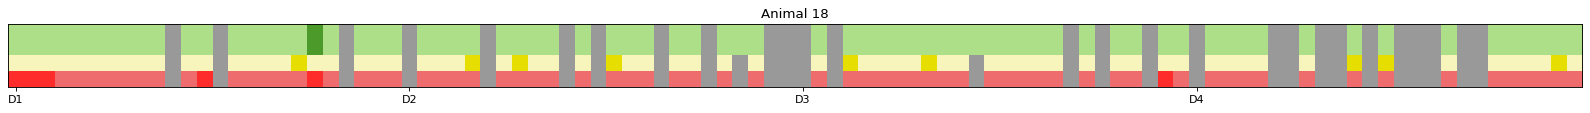

Time peak: 0.07 Time ss: 0.02
Dur peak: 1.1 Dur ss: 0.7
Freq peak: 3.8 Freq ss: 1.2


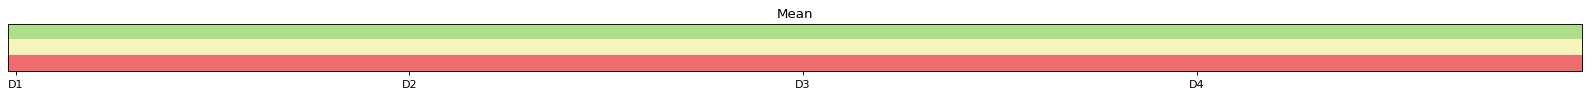

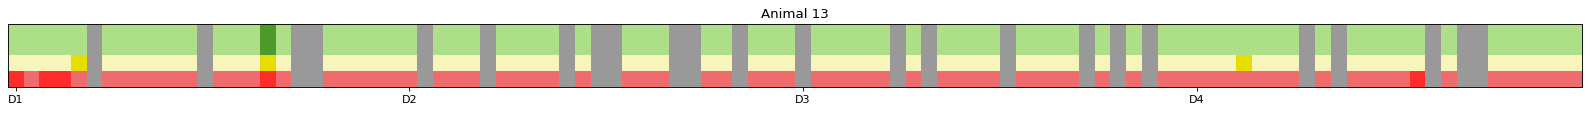

Time peak: 0.06 Time ss: 0.02
Dur peak: 1.0 Dur ss: 0.7
Freq peak: 3.0 Freq ss: 1.1


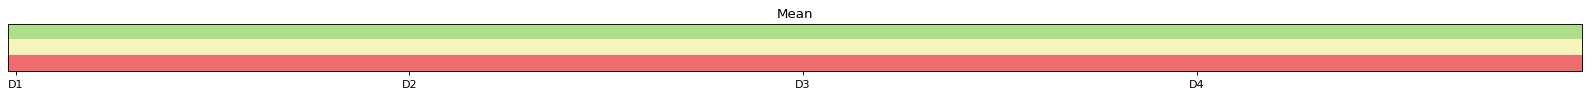

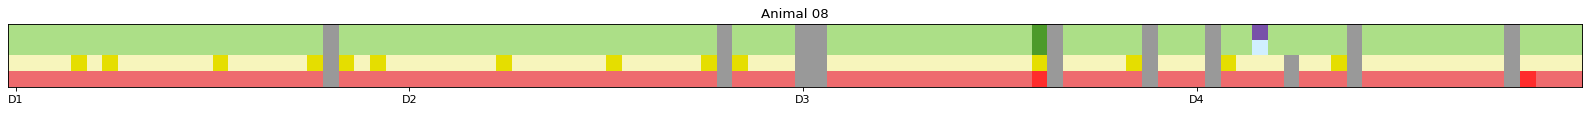

Time peak: 0.03 Time ss: 0.02
Dur peak: 1.1 Dur ss: 0.8
Freq peak: 1.8 Freq ss: 1.5


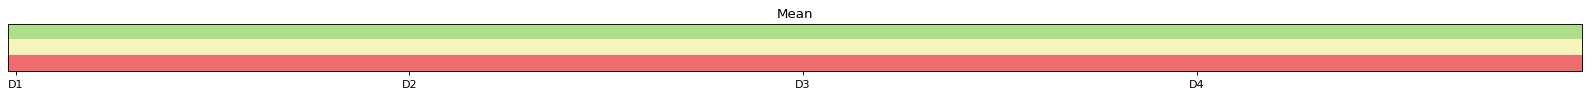

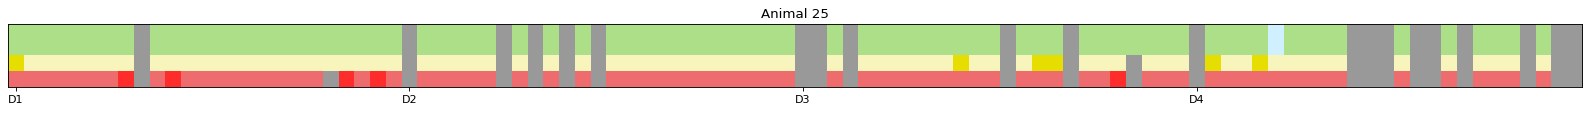

Time peak: 0.03 Time ss: 0.02
Dur peak: 0.8 Dur ss: 0.8
Freq peak: 2.2 Freq ss: 1.1


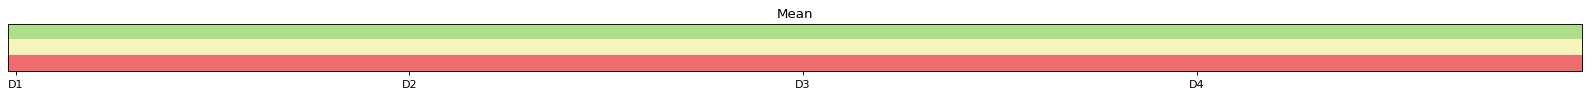

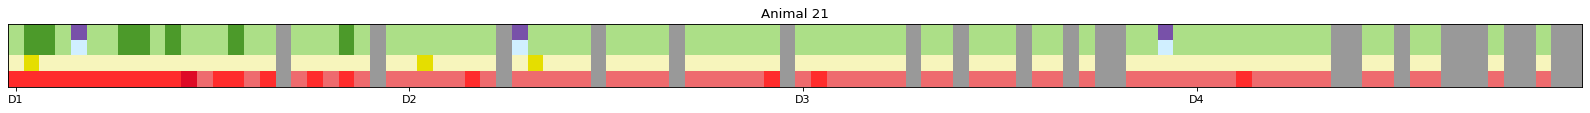

Time peak: 0.09 Time ss: 0.02
Dur peak: 1.1 Dur ss: 0.6
Freq peak: 4.9 Freq ss: 1.3


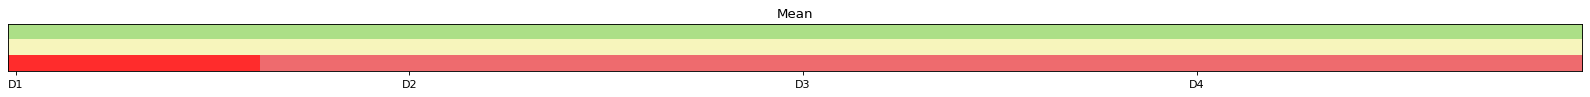

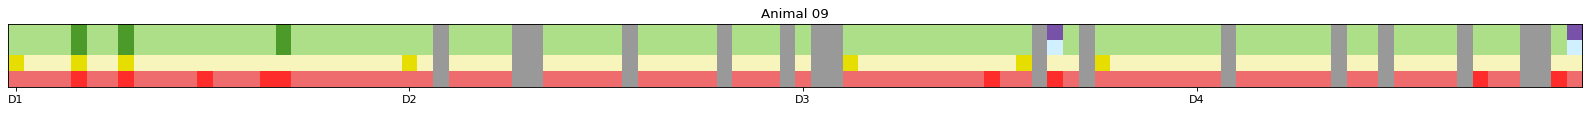

Time peak: 0.05 Time ss: 0.02
Dur peak: 1.0 Dur ss: 0.7
Freq peak: 2.8 Freq ss: 1.4


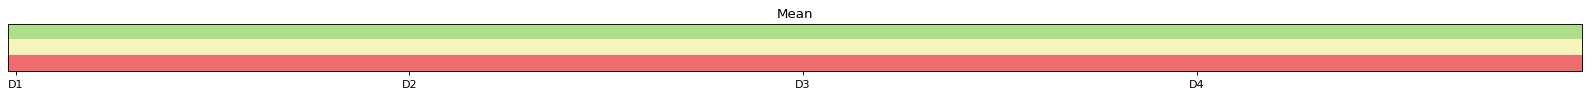

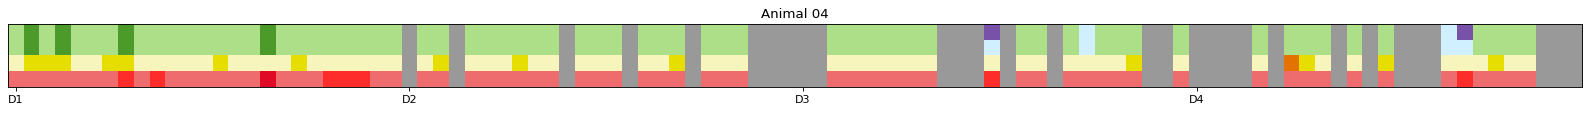

Time peak: 0.06 Time ss: 0.02
Dur peak: 1.3 Dur ss: 0.7
Freq peak: 3.0 Freq ss: 0.9


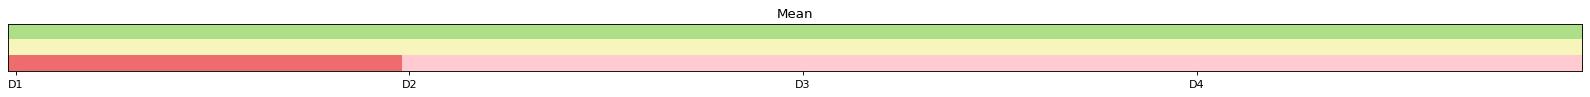

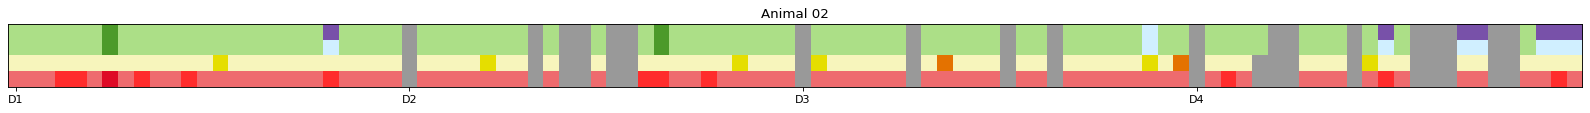

Time peak: 0.04 Time ss: 0.02
Dur peak: 0.9 Dur ss: 0.7
Freq peak: 2.6 Freq ss: 1.4


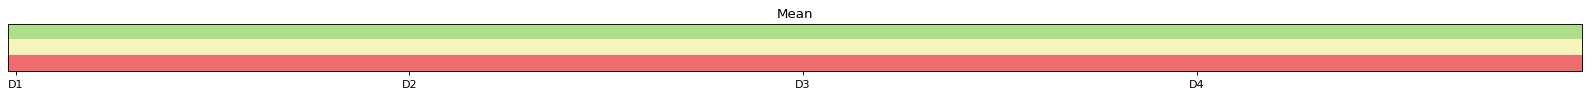

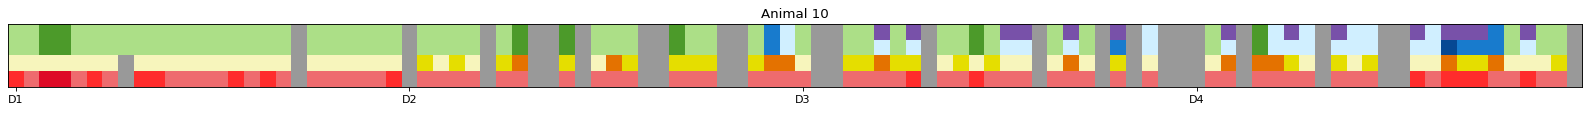

Time caut: 0.05 Time conf: 0.07
Dur caut: 1.3 Dur conf: 1.7
Freq cau: 1.8 Freq conf: 1.8


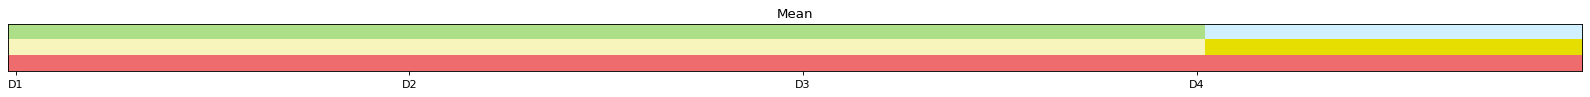

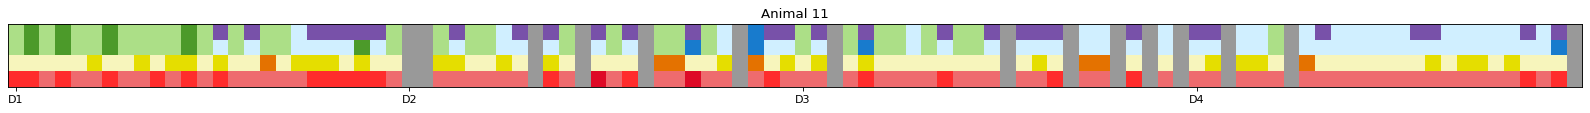

Time caut: 0.07 Time conf: 0.04
Dur caut: 1.4 Dur conf: 1.2
Freq cau: 3.1 Freq conf: 2.0


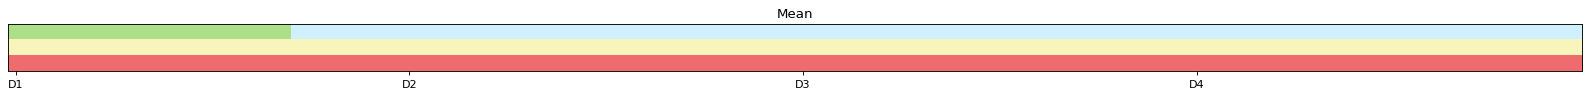

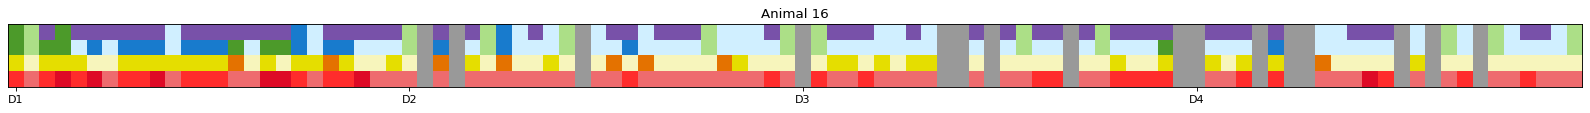

Time caut: 0.11 Time con-peak: 0.15 Time con-ss: 0.04
Dur caut: 1.6 Dur con-peak: 2.0 Dur con-ss: 1.1
Freq cau: 4.8 Freq con-peak: 4.6 Freq con-ss: 2.0


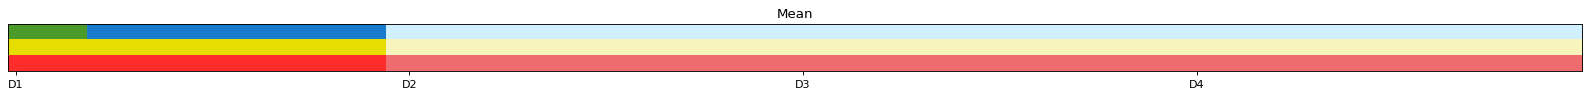

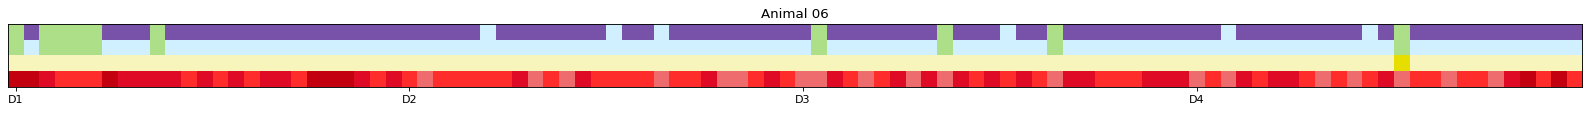

Time caut: 0.07 Time conf: 0.04
Dur caut: 0.6 Dur conf: 0.5
Freq cau: 7.7 Freq conf: 5.3


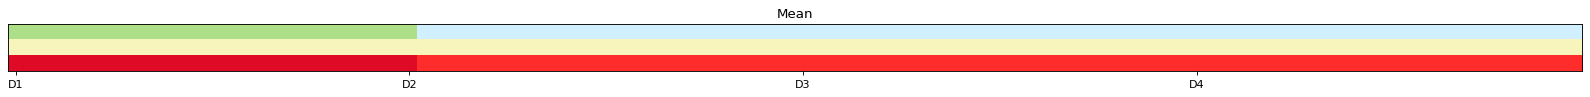

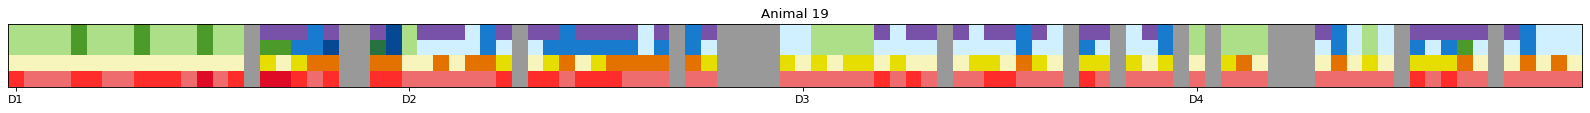

Time caut: 0.07 Time con-peak: 0.14 Time con-ss: 0.05
Dur caut: 1.0 Dur con-peak: 2.8 Dur con-ss: 1.4
Freq cau: 3.8 Freq con-peak: 3.1 Freq con-ss: 1.8


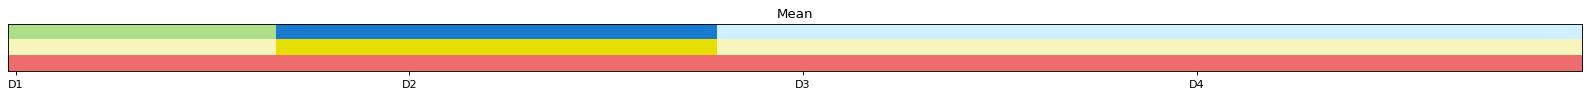

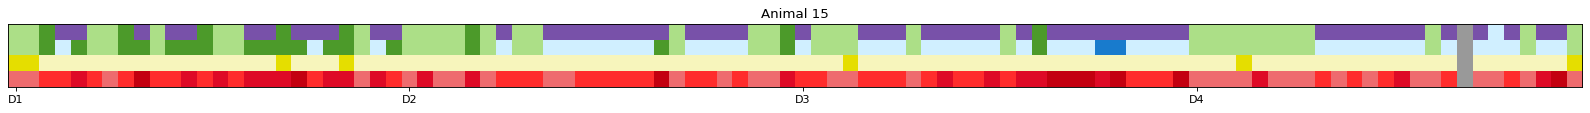

Time peak: 0.10 Time ss: 0.06
Dur peak: 1.1 Dur ss: 0.8
Freq peak: 5.9 Freq ss: 4.8


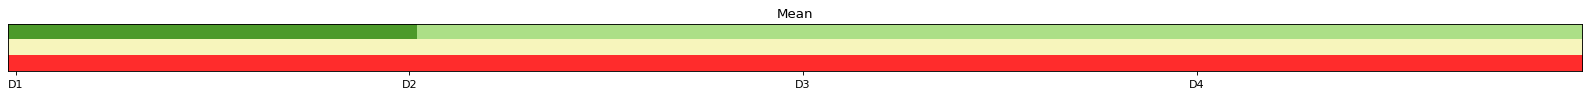

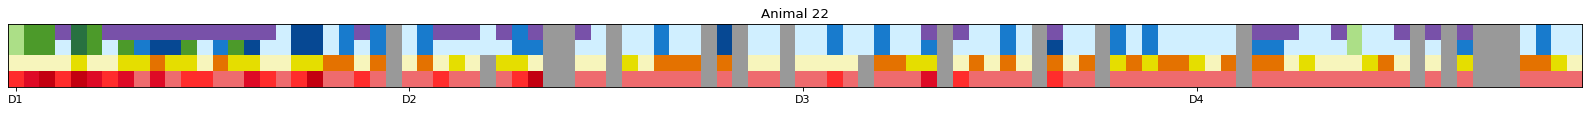

Time caut: 0.16 Time con-peak: 0.22 Time con-ss: 0.06
Dur caut: 1.5 Dur con-peak: 3.2 Dur con-ss: 2.0
Freq cau: 6.8 Freq con-peak: 4.7 Freq con-ss: 1.7


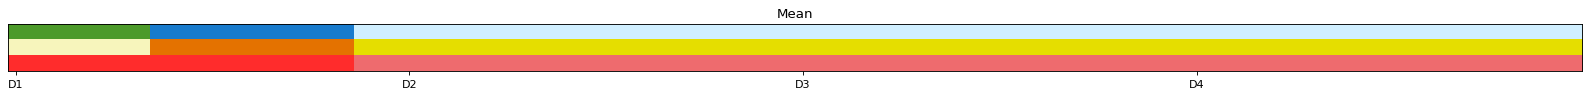

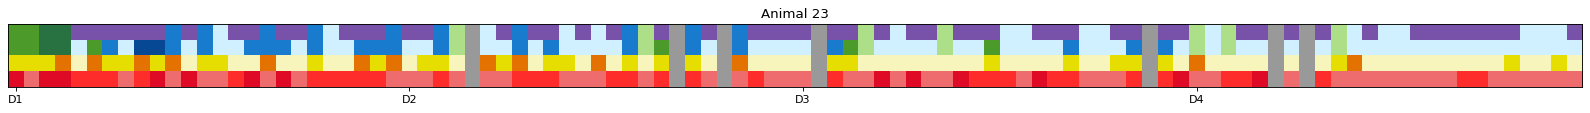

Time caut: 0.25 Time con-peak: 0.15 Time con-ss: 0.06
Dur caut: 2.3 Dur con-peak: 2.3 Dur con-ss: 1.2
Freq cau: 6.2 Freq con-peak: 4.1 Freq con-ss: 3.1


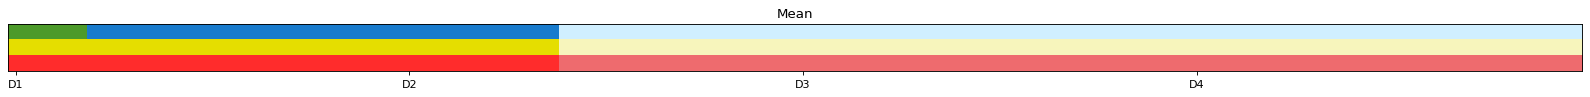

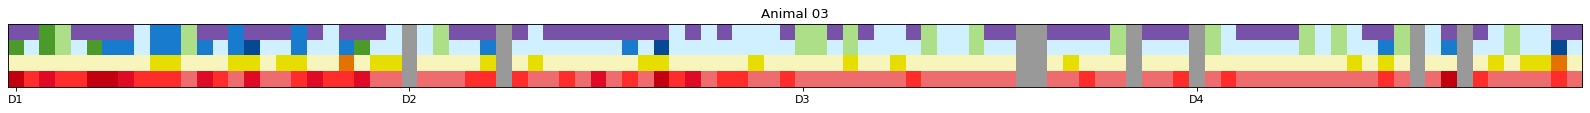

Time caut: 0.12 Time con-peak: 0.10 Time con-ss: 0.05
Dur caut: 1.0 Dur con-peak: 1.2 Dur con-ss: 0.9
Freq cau: 7.5 Freq con-peak: 4.4 Freq con-ss: 2.4


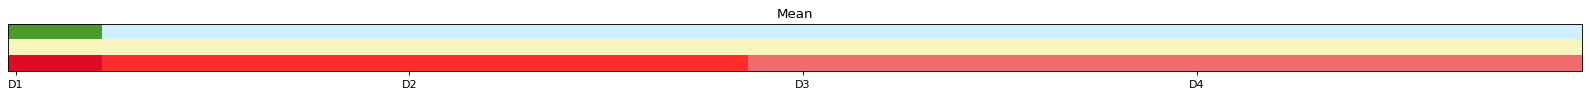

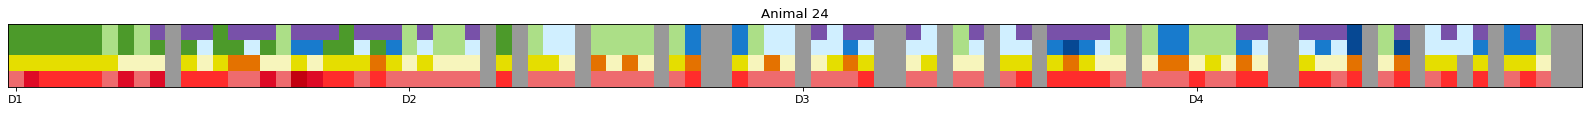

Time caut: 0.15 Time conf: 0.07
Dur caut: 1.8 Dur conf: 1.5
Freq cau: 4.8 Freq conf: 1.9


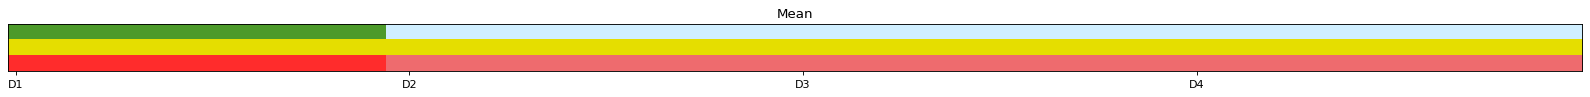

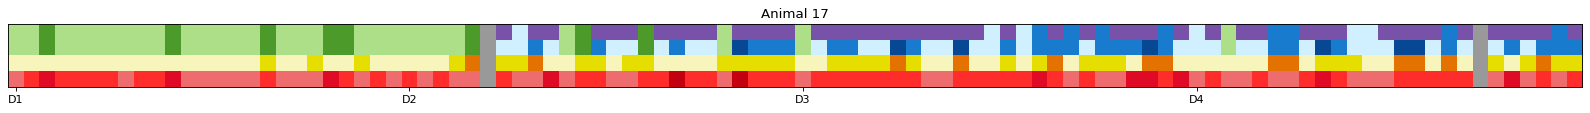

Time caut: 0.07 Time conf: 0.14
Dur caut: 1.2 Dur conf: 1.9
Freq cau: 3.7 Freq conf: 4.3


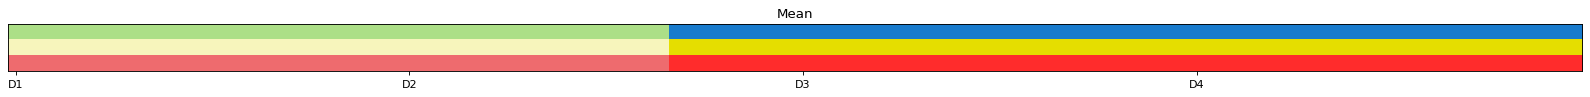

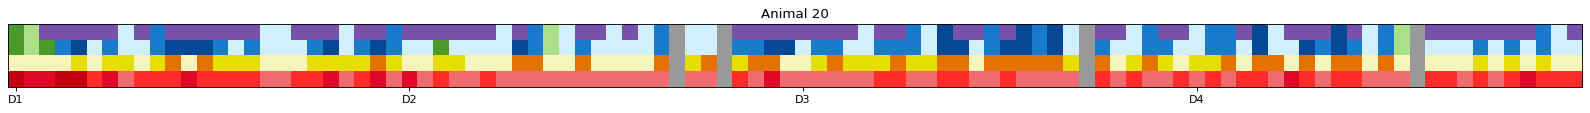

Time caut: 0.15 Time con-peak: 0.20 Time con-ss: 0.14
Dur caut: 1.0 Dur con-peak: 2.2 Dur con-ss: 3.3
Freq cau: 9.0 Freq con-peak: 5.3 Freq con-ss: 2.9


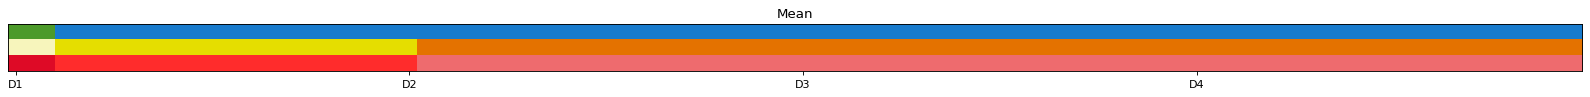

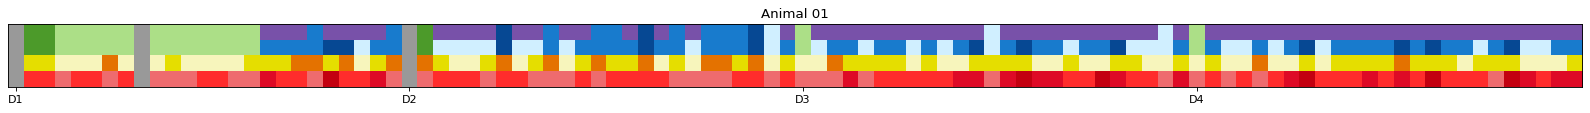

Time caut: 0.08 Time conf: 0.16
Dur caut: 1.4 Dur conf: 2.2
Freq cau: 3.1 Freq conf: 5.0


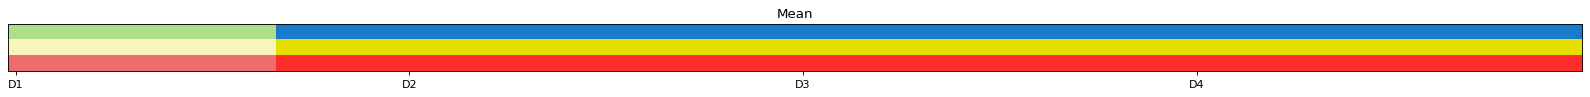

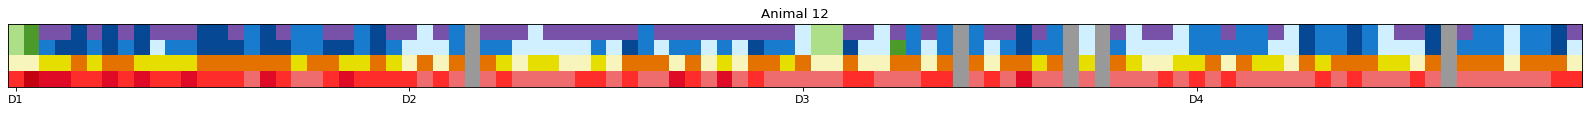

Time caut: 0.16 Time con-peak: 0.31 Time con-ss: 0.14
Dur caut: 1.4 Dur con-peak: 3.4 Dur con-ss: 2.9
Freq cau: 7.0 Freq con-peak: 5.6 Freq con-ss: 2.9


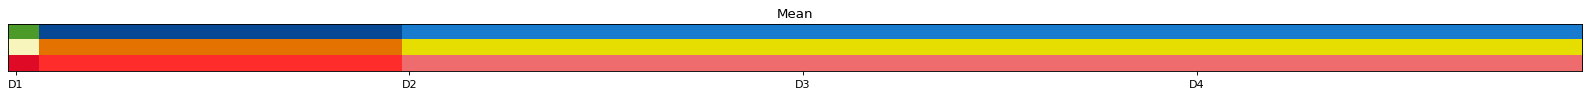

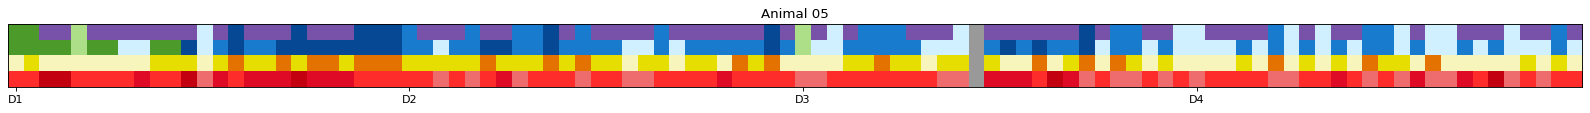

Time caut: 0.16 Time con-peak: 0.41 Time con-ss: 0.14
Dur caut: 1.4 Dur con-peak: 3.5 Dur con-ss: 2.0
Freq cau: 6.7 Freq con-peak: 7.3 Freq con-ss: 4.5


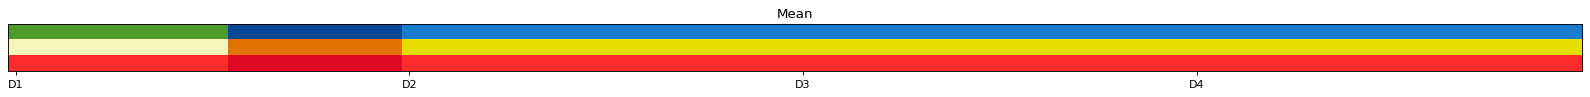

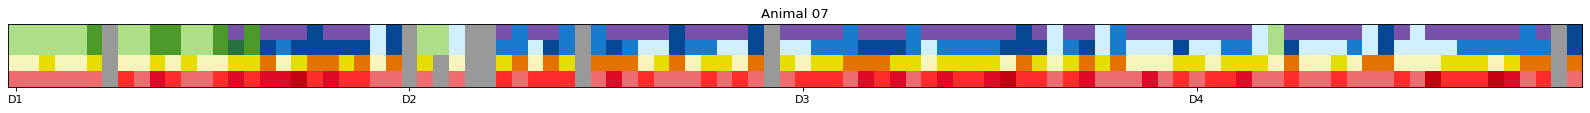

Time caut: 0.10 Time con-peak: 0.39 Time con-ss: 0.17
Dur caut: 1.4 Dur con-peak: 4.0 Dur con-ss: 3.2
Freq cau: 3.6 Freq con-peak: 6.4 Freq con-ss: 4.0


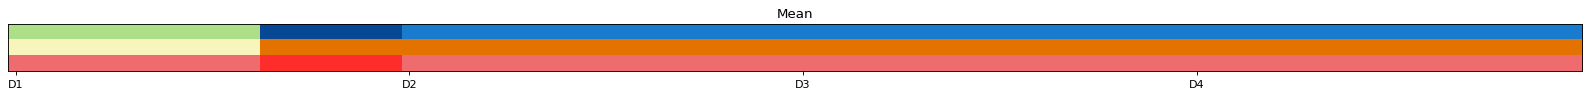

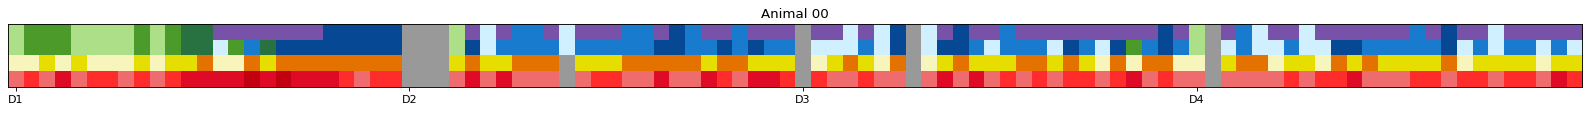

Time caut: 0.13 Time con-peak: 0.41 Time con-ss: 0.17
Dur caut: 1.6 Dur con-peak: 4.4 Dur con-ss: 3.0
Freq cau: 4.8 Freq con-peak: 6.2 Freq con-ss: 3.6


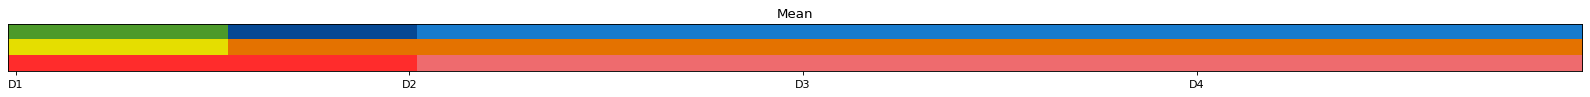

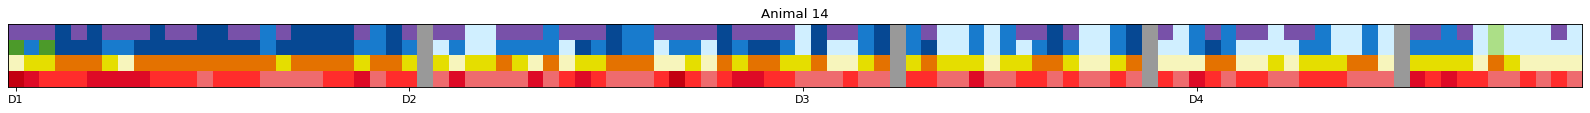

Time caut: 0.24 Time con-peak: 0.44 Time con-ss: 0.15
Dur caut: 2.3 Dur con-peak: 7.1 Dur con-ss: 2.6
Freq cau: 7.0 Freq con-peak: 5.3 Freq con-ss: 3.8


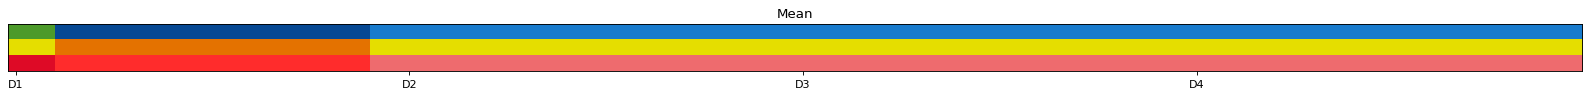

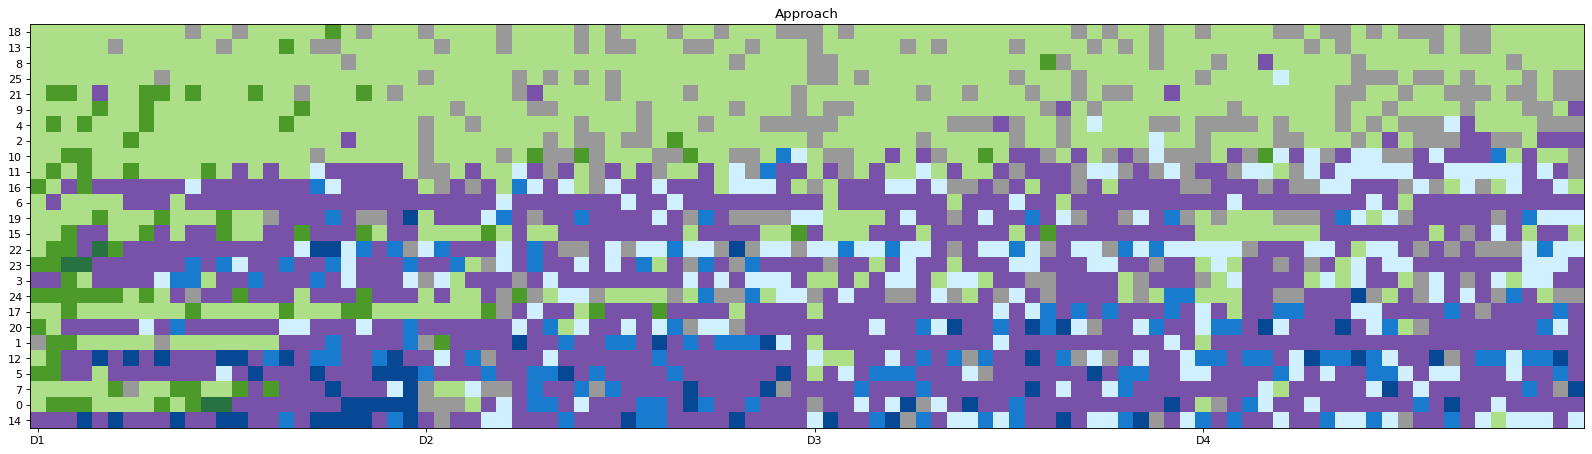

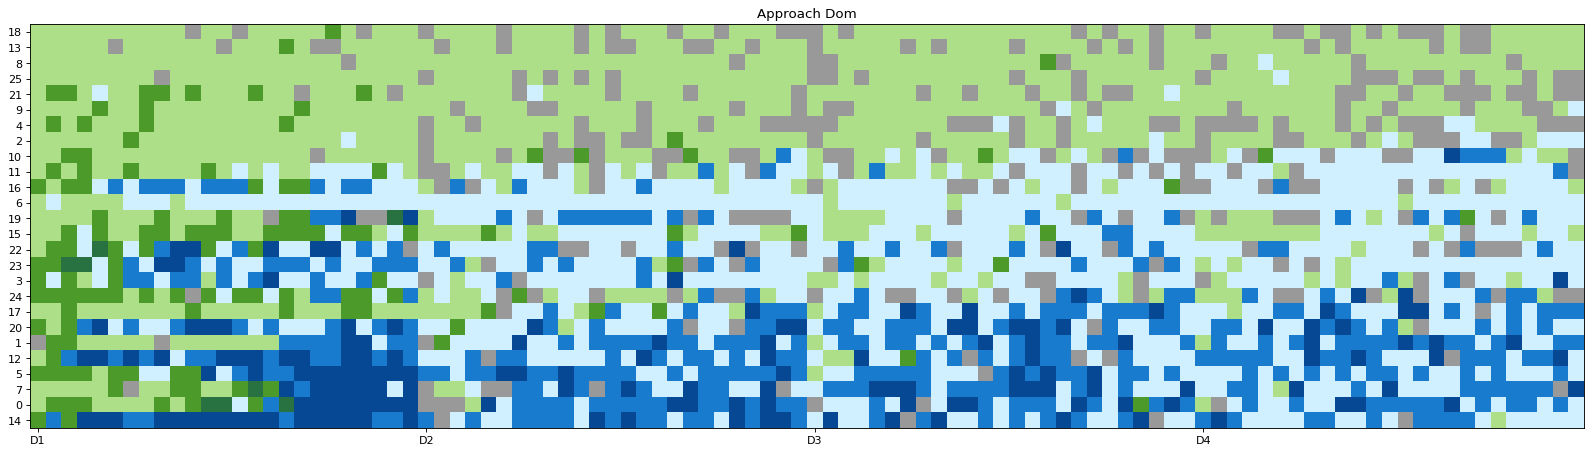

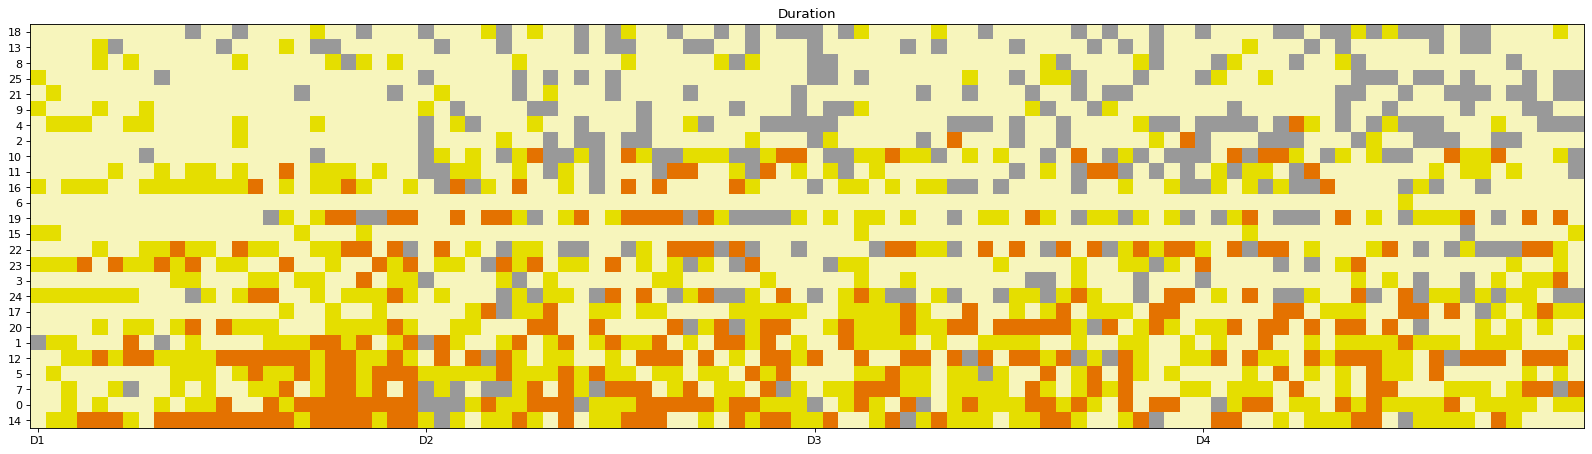

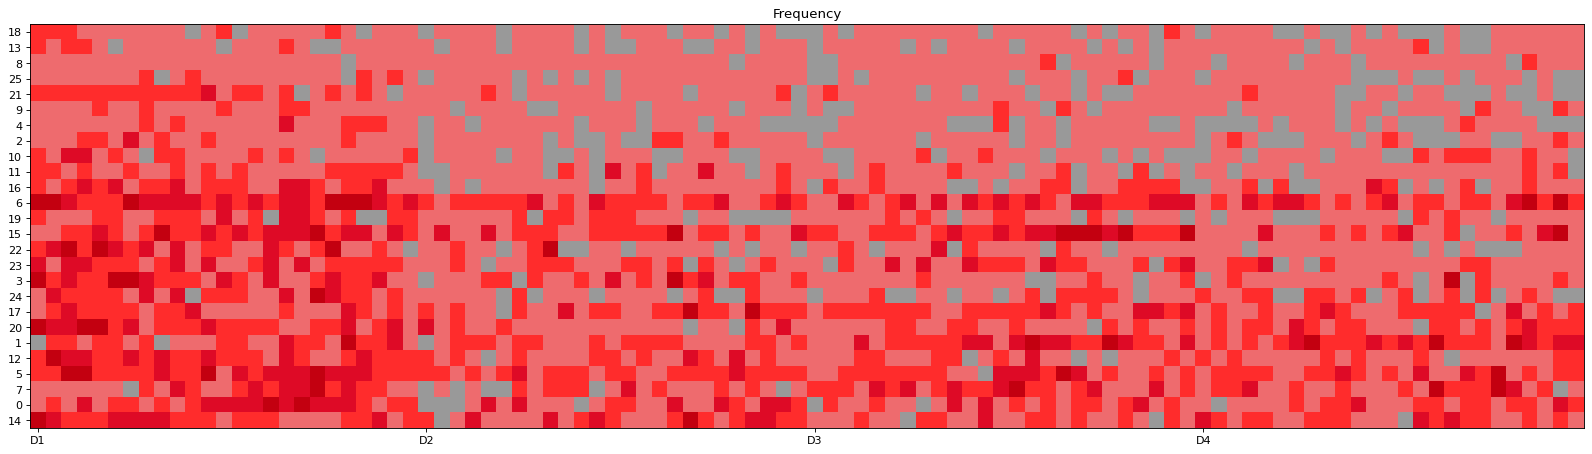

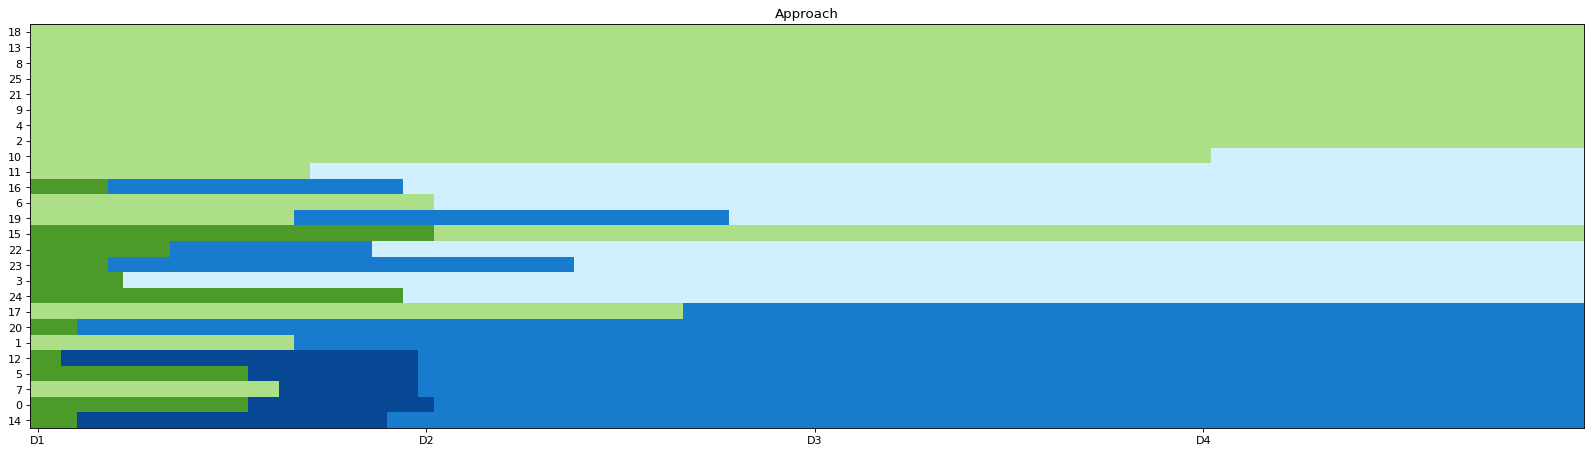

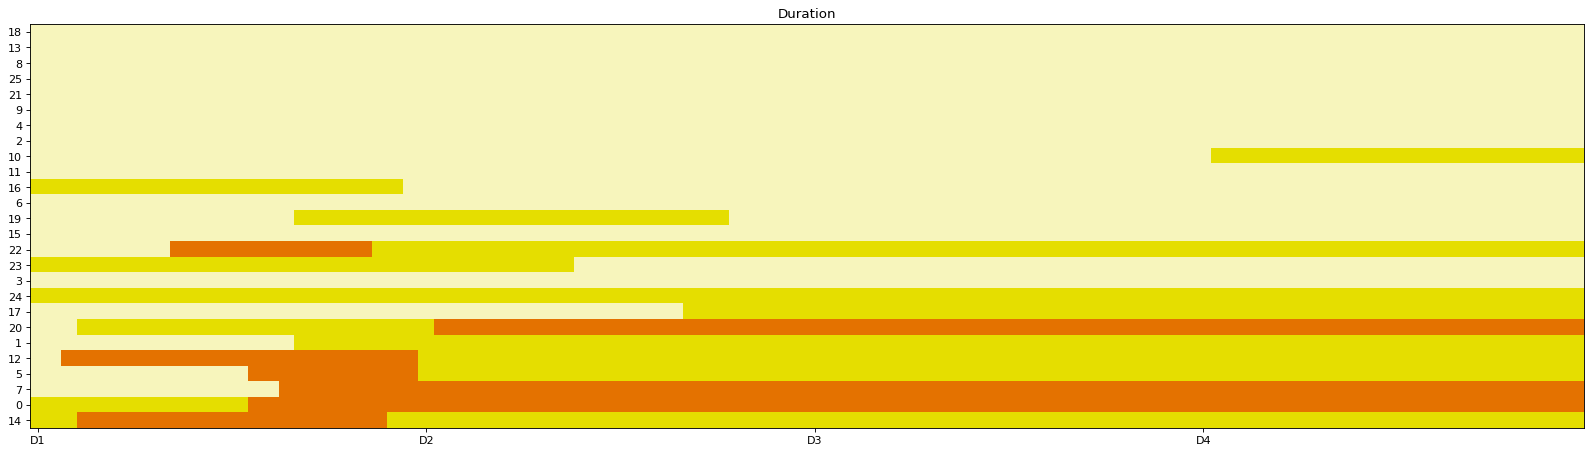

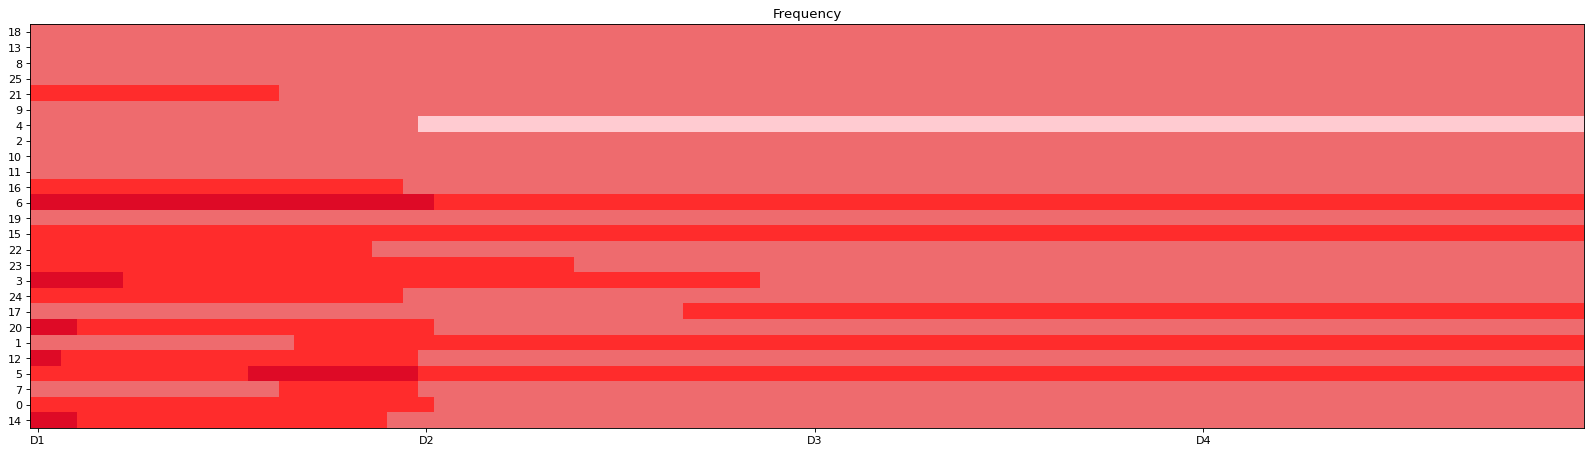

In [13]:
traj_bars(near, near_front, near_behind, bout_duration_avg, bout_freq, print_fn=None, 
          write_targ=True, smooth_window=None)